In [75]:
import pandas as pd
import numpy as np
import random
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
# Read Data from php server
myLocationData = pd.read_html('https://serwer1990534.home.pl/LocationData.php')

In [9]:
# Drop unsignificant data and change column names
location_df = myLocationData[0]
location_df = location_df[220:-1]
location_df = location_df.drop([0,5], axis = 1)
location_df = location_df.rename(columns={1:'place_name',2:'place_types',3:'presence_likelihood',4:"datetime"})

# get only the best likelihoods of certain time
likelihood_maxes = location_df.groupby(['datetime']).presence_likelihood.transform(max)
location_df_max_likelihood = location_df.loc[location_df.presence_likelihood == likelihood_maxes]
location_df_max_likelihood = location_df_max_likelihood.reset_index(drop = True)
location_df_max_likelihood = location_df_max_likelihood.sort_values('datetime', ascending = False)


# Change strring type to datetime (easy getter for cartain datatime types)
location_df_max_likelihood['datetime'] = pd.to_datetime(location_df_max_likelihood['datetime'], format='%m-%d-%Y %H:%M:%S')

# Generate columns for all types
for index, row in location_df_max_likelihood.iterrows():
    string_to_chop = row['place_types'][:-1]
    types = [x.strip() for x in string_to_chop.split(',')]
    for number,location_type in enumerate(types, start=1):
        location_df_max_likelihood.loc[index,'type_' + str(number)] = location_type
        
# Fill all none types with 0
location_df_max_likelihood = location_df_max_likelihood.fillna(0)

# Drop comas place types
# location_df_max_likelihood = location_df_max_likelihood.drop(['place_types'], axis=1)

In [10]:
# Get all column names
type_columns = location_df_max_likelihood.columns[4:]

In [11]:
type_columns

Index(['type_1', 'type_2', 'type_3', 'type_4', 'type_5', 'type_6', 'type_7',
       'type_8', 'type_9', 'type_10', 'type_11', 'type_12'],
      dtype='object')

In [12]:
# Find most popular types per last week day and 4 hour for every rows
for index, row in location_df_max_likelihood.iterrows():
    searching = True
    iterator = 0
# Existed places dictionaries
    dictionary_4_hour = {}
    dictionary_1_day = {}
    dictionary_7_days = {}
# Main lopp looking on past 7 days places 
    while searching == True:  
        current_row = location_df_max_likelihood.iloc[index - iterator]        
        for type_name in type_columns:
            place_type = current_row[type_name]
            if place_type != 0 and place_type !="POINT_OF_INTEREST" and place_type !="ESTABLISHMENT":
                if place_type in dictionary_4_hour.keys() and iterator <= 12:
                    dictionary_4_hour[place_type] += 1
                else:
                    dictionary_4_hour[place_type]  = 1
                if place_type in dictionary_1_day.keys() and iterator <= 54:
                    dictionary_1_day[place_type] += 1
                else:
                    dictionary_1_day[place_type] = 1
                if place_type in dictionary_7_days.keys() and iterator <= 378:
                    dictionary_7_days[place_type] += 1
                else:
                    dictionary_7_days[place_type] = 1
        iterator += 1
        if index - iterator < 0 or iterator > 378:
            searching = False
# Search most frequent places in certain datatime frames
    max_4_hour_type = max(dictionary_4_hour, key=dictionary_4_hour.get)
    max_1_day_type = max(dictionary_1_day, key=dictionary_1_day.get)
    max_7_days_type = max(dictionary_7_days, key=dictionary_7_days.get)
# Set most frequent places in certain datatimes
    location_df_max_likelihood.loc[index, 'type_4_hours'] = max_4_hour_type
    location_df_max_likelihood.loc[index, 'type_1_day'] = max_1_day_type
    location_df_max_likelihood.loc[index, 'type_7_days'] = max_7_days_type  
    
    print(index,"row data filled with")

location_df_max_likelihood.to_csv('frequent_locations.csv')

11330 row data filled with
11329 row data filled with
11328 row data filled with
11327 row data filled with
11326 row data filled with
11325 row data filled with
11324 row data filled with
11323 row data filled with
11322 row data filled with
11321 row data filled with
11320 row data filled with
11319 row data filled with
11318 row data filled with
11317 row data filled with
11316 row data filled with
11315 row data filled with
11314 row data filled with
11313 row data filled with
11312 row data filled with
11311 row data filled with
11310 row data filled with
11309 row data filled with
11308 row data filled with
11307 row data filled with
11306 row data filled with
11305 row data filled with
11304 row data filled with
11303 row data filled with
11302 row data filled with
11301 row data filled with
11300 row data filled with
11299 row data filled with
11298 row data filled with
11297 row data filled with
11296 row data filled with
11295 row data filled with
11294 row data filled with
1

KeyboardInterrupt: 

In [13]:
frequent_location_df = pd.read_csv('frequent_locations.csv')

In [14]:
frequent_location_df = frequent_location_df.drop(['Unnamed: 0'], axis = 1)

In [15]:
frequent_location_df.datetime = pd.to_datetime(frequent_location_df.datetime, format='%Y-%m-%d %H:%M:%S' )


In [16]:
days = frequent_location_df['datetime'].dt.weekday
hours = frequent_location_df['datetime'].dt.hour
mins = frequent_location_df['datetime'].dt.minute

In [17]:
frequent_location_df['weekday'] = days
frequent_location_df['mins'] = mins
frequent_location_df['hours'] = hours


In [18]:
frequent_location_df.shape[0]

11331

In [19]:
frequent_location_df['week_bfr_4_hours'] = '0'
frequent_location_df['week_bfr_1_day'] = '0'
frequent_location_df['week_bfr_7_days'] = '0'



In [25]:
# Find most popular types from time exactly 7 days ago
for index, row in frequent_location_df.iterrows():
    row_weekday = row.weekday
    row_hour = row.hours
    row_mins = row.mins
    iterator = 340
    searching = True
    if(iterator+index < frequent_location_df.shape[0] - 1):
        while searching == True:  
            current_row = frequent_location_df.iloc[index + iterator]
            if(current_row.weekday == row_weekday):
                if(current_row.hours == row_hour):
                    if(current_row.mins == row_mins):
                        frequent_location_df.loc[index, 'week_bfr_4_hours'] = current_row.type_4_hours
                        frequent_location_df.loc[index, 'week_bfr_1_day'] = current_row.type_1_day
                        print(index, 'row updated normally')
                        break
            if(iterator >= 380 or iterator + index >= frequent_location_df.shape[0] - 1):
                frequent_location_df.loc[index, 'week_bfr_4_hours'] = current_row.type_4_hours
                frequent_location_df.loc[index, 'week_bfr_1_day'] = current_row.type_1_day
                frequent_location_df.loc[index, 'week_bfr_7_days'] = current_row.type_7_days
                searching = False
                print(index, 'row updated because lack of data')
            iterator += 1
    else:
        frequent_location_df.loc[index, 'week_bfr_4_hours'] = 0
        frequent_location_df.loc[index, 'week_bfr_1_day'] = 0
        frequent_location_df.loc[index, 'week_bfr_7_days'] = 0

frequent_location_df.to_csv('location_with_last_week_info.csv')

0 row updated normally
1 row updated normally
2 row updated normally
3 row updated normally
4 row updated normally
5 row updated normally
6 row updated normally
7 row updated normally
8 row updated normally
9 row updated normally
10 row updated normally
11 row updated normally
12 row updated normally
13 row updated normally
14 row updated normally
15 row updated normally
16 row updated normally
17 row updated normally
18 row updated normally
19 row updated normally
20 row updated normally
21 row updated normally
22 row updated normally
23 row updated normally
24 row updated normally
25 row updated normally
26 row updated normally
27 row updated normally
28 row updated normally
29 row updated normally
30 row updated normally
31 row updated normally
32 row updated normally
33 row updated normally
34 row updated normally
35 row updated normally
36 row updated normally
37 row updated normally
38 row updated normally
39 row updated normally
40 row updated normally
41 row updated normally
42

339 row updated normally
340 row updated normally
341 row updated normally
342 row updated normally
343 row updated normally
344 row updated normally
345 row updated normally
346 row updated because lack of data
347 row updated normally
348 row updated because lack of data
349 row updated normally
350 row updated normally
351 row updated normally
352 row updated normally
353 row updated normally
354 row updated normally
355 row updated normally
356 row updated normally
357 row updated normally
358 row updated normally
359 row updated because lack of data
360 row updated because lack of data
361 row updated normally
362 row updated normally
363 row updated because lack of data
364 row updated normally
365 row updated normally
366 row updated normally
367 row updated normally
368 row updated normally
369 row updated normally
370 row updated normally
371 row updated normally
372 row updated normally
373 row updated normally
374 row updated normally
375 row updated normally
376 row updated

661 row updated normally
662 row updated normally
663 row updated normally
664 row updated normally
665 row updated normally
666 row updated normally
667 row updated normally
668 row updated normally
669 row updated normally
670 row updated normally
671 row updated normally
672 row updated normally
673 row updated normally
674 row updated normally
675 row updated normally
676 row updated normally
677 row updated normally
678 row updated normally
679 row updated normally
680 row updated normally
681 row updated normally
682 row updated normally
683 row updated normally
684 row updated normally
685 row updated normally
686 row updated normally
687 row updated normally
688 row updated normally
689 row updated normally
690 row updated normally
691 row updated normally
692 row updated normally
693 row updated normally
694 row updated normally
695 row updated normally
696 row updated normally
697 row updated normally
698 row updated normally
699 row updated normally
700 row updated normally


998 row updated normally
999 row updated normally
1000 row updated normally
1001 row updated normally
1002 row updated normally
1003 row updated normally
1004 row updated normally
1005 row updated normally
1006 row updated normally
1007 row updated normally
1008 row updated normally
1009 row updated normally
1010 row updated normally
1011 row updated normally
1012 row updated normally
1013 row updated normally
1014 row updated normally
1015 row updated normally
1016 row updated normally
1017 row updated normally
1018 row updated normally
1019 row updated normally
1020 row updated normally
1021 row updated normally
1022 row updated normally
1023 row updated normally
1024 row updated normally
1025 row updated normally
1026 row updated normally
1027 row updated normally
1028 row updated normally
1029 row updated normally
1030 row updated normally
1031 row updated normally
1032 row updated normally
1033 row updated normally
1034 row updated normally
1035 row updated normally
1036 row updat

1316 row updated normally
1317 row updated normally
1318 row updated normally
1319 row updated normally
1320 row updated normally
1321 row updated normally
1322 row updated normally
1323 row updated normally
1324 row updated normally
1325 row updated normally
1326 row updated normally
1327 row updated normally
1328 row updated normally
1329 row updated normally
1330 row updated normally
1331 row updated normally
1332 row updated normally
1333 row updated normally
1334 row updated normally
1335 row updated normally
1336 row updated normally
1337 row updated normally
1338 row updated normally
1339 row updated normally
1340 row updated normally
1341 row updated normally
1342 row updated normally
1343 row updated normally
1344 row updated normally
1345 row updated normally
1346 row updated normally
1347 row updated normally
1348 row updated normally
1349 row updated normally
1350 row updated normally
1351 row updated normally
1352 row updated normally
1353 row updated normally
1354 row upd

1638 row updated because lack of data
1639 row updated normally
1640 row updated normally
1641 row updated normally
1642 row updated normally
1643 row updated normally
1644 row updated normally
1645 row updated normally
1646 row updated normally
1647 row updated normally
1648 row updated normally
1649 row updated normally
1650 row updated normally
1651 row updated normally
1652 row updated normally
1653 row updated normally
1654 row updated normally
1655 row updated normally
1656 row updated normally
1657 row updated normally
1658 row updated normally
1659 row updated normally
1660 row updated normally
1661 row updated normally
1662 row updated normally
1663 row updated normally
1664 row updated normally
1665 row updated normally
1666 row updated normally
1667 row updated normally
1668 row updated normally
1669 row updated normally
1670 row updated because lack of data
1671 row updated normally
1672 row updated normally
1673 row updated normally
1674 row updated normally
1675 row updat

1920 row updated normally
1921 row updated normally
1922 row updated normally
1923 row updated normally
1924 row updated normally
1925 row updated normally
1926 row updated normally
1927 row updated normally
1928 row updated normally
1929 row updated normally
1930 row updated normally
1931 row updated normally
1932 row updated normally
1933 row updated normally
1934 row updated normally
1935 row updated normally
1936 row updated normally
1937 row updated normally
1938 row updated normally
1939 row updated because lack of data
1940 row updated because lack of data
1941 row updated because lack of data
1942 row updated normally
1943 row updated normally
1944 row updated normally
1945 row updated normally
1946 row updated normally
1947 row updated normally
1948 row updated normally
1949 row updated normally
1950 row updated normally
1951 row updated normally
1952 row updated normally
1953 row updated normally
1954 row updated normally
1955 row updated normally
1956 row updated normally
19

2173 row updated because lack of data
2174 row updated because lack of data
2175 row updated because lack of data
2176 row updated because lack of data
2177 row updated because lack of data
2178 row updated because lack of data
2179 row updated because lack of data
2180 row updated because lack of data
2181 row updated because lack of data
2182 row updated because lack of data
2183 row updated because lack of data
2184 row updated because lack of data
2185 row updated because lack of data
2186 row updated because lack of data
2187 row updated because lack of data
2188 row updated because lack of data
2189 row updated because lack of data
2190 row updated because lack of data
2191 row updated because lack of data
2192 row updated because lack of data
2193 row updated because lack of data
2194 row updated because lack of data
2195 row updated because lack of data
2196 row updated because lack of data
2197 row updated because lack of data
2198 row updated because lack of data
2199 row upd

2390 row updated because lack of data
2391 row updated because lack of data
2392 row updated because lack of data
2393 row updated because lack of data
2394 row updated because lack of data
2395 row updated because lack of data
2396 row updated because lack of data
2397 row updated because lack of data
2398 row updated because lack of data
2399 row updated because lack of data
2400 row updated because lack of data
2401 row updated because lack of data
2402 row updated because lack of data
2403 row updated because lack of data
2404 row updated because lack of data
2405 row updated because lack of data
2406 row updated because lack of data
2407 row updated because lack of data
2408 row updated because lack of data
2409 row updated because lack of data
2410 row updated because lack of data
2411 row updated because lack of data
2412 row updated because lack of data
2413 row updated because lack of data
2414 row updated because lack of data
2415 row updated because lack of data
2416 row upd

2612 row updated because lack of data
2613 row updated because lack of data
2614 row updated because lack of data
2615 row updated because lack of data
2616 row updated because lack of data
2617 row updated because lack of data
2618 row updated because lack of data
2619 row updated because lack of data
2620 row updated because lack of data
2621 row updated because lack of data
2622 row updated because lack of data
2623 row updated because lack of data
2624 row updated because lack of data
2625 row updated because lack of data
2626 row updated because lack of data
2627 row updated because lack of data
2628 row updated because lack of data
2629 row updated because lack of data
2630 row updated because lack of data
2631 row updated because lack of data
2632 row updated because lack of data
2633 row updated because lack of data
2634 row updated because lack of data
2635 row updated because lack of data
2636 row updated because lack of data
2637 row updated because lack of data
2638 row upd

2834 row updated because lack of data
2835 row updated because lack of data
2836 row updated because lack of data
2837 row updated because lack of data
2838 row updated because lack of data
2839 row updated because lack of data
2840 row updated because lack of data
2841 row updated because lack of data
2842 row updated because lack of data
2843 row updated because lack of data
2844 row updated because lack of data
2845 row updated because lack of data
2846 row updated because lack of data
2847 row updated because lack of data
2848 row updated because lack of data
2849 row updated because lack of data
2850 row updated because lack of data
2851 row updated because lack of data
2852 row updated because lack of data
2853 row updated because lack of data
2854 row updated because lack of data
2855 row updated because lack of data
2856 row updated because lack of data
2857 row updated because lack of data
2858 row updated because lack of data
2859 row updated because lack of data
2860 row upd

3059 row updated because lack of data
3060 row updated because lack of data
3061 row updated because lack of data
3062 row updated because lack of data
3063 row updated because lack of data
3064 row updated because lack of data
3065 row updated because lack of data
3066 row updated because lack of data
3067 row updated because lack of data
3068 row updated because lack of data
3069 row updated because lack of data
3070 row updated because lack of data
3071 row updated because lack of data
3072 row updated because lack of data
3073 row updated because lack of data
3074 row updated because lack of data
3075 row updated because lack of data
3076 row updated because lack of data
3077 row updated because lack of data
3078 row updated because lack of data
3079 row updated because lack of data
3080 row updated because lack of data
3081 row updated because lack of data
3082 row updated because lack of data
3083 row updated because lack of data
3084 row updated because lack of data
3085 row upd

3285 row updated because lack of data
3286 row updated because lack of data
3287 row updated because lack of data
3288 row updated because lack of data
3289 row updated because lack of data
3290 row updated because lack of data
3291 row updated because lack of data
3292 row updated because lack of data
3293 row updated because lack of data
3294 row updated because lack of data
3295 row updated because lack of data
3296 row updated because lack of data
3297 row updated because lack of data
3298 row updated because lack of data
3299 row updated because lack of data
3300 row updated because lack of data
3301 row updated because lack of data
3302 row updated because lack of data
3303 row updated because lack of data
3304 row updated because lack of data
3305 row updated because lack of data
3306 row updated because lack of data
3307 row updated because lack of data
3308 row updated because lack of data
3309 row updated because lack of data
3310 row updated because lack of data
3311 row upd

3502 row updated because lack of data
3503 row updated because lack of data
3504 row updated because lack of data
3505 row updated because lack of data
3506 row updated because lack of data
3507 row updated because lack of data
3508 row updated because lack of data
3509 row updated because lack of data
3510 row updated because lack of data
3511 row updated because lack of data
3512 row updated because lack of data
3513 row updated because lack of data
3514 row updated because lack of data
3515 row updated because lack of data
3516 row updated because lack of data
3517 row updated because lack of data
3518 row updated because lack of data
3519 row updated because lack of data
3520 row updated because lack of data
3521 row updated because lack of data
3522 row updated because lack of data
3523 row updated because lack of data
3524 row updated because lack of data
3525 row updated because lack of data
3526 row updated because lack of data
3527 row updated because lack of data
3528 row upd

3727 row updated because lack of data
3728 row updated because lack of data
3729 row updated because lack of data
3730 row updated because lack of data
3731 row updated because lack of data
3732 row updated because lack of data
3733 row updated because lack of data
3734 row updated because lack of data
3735 row updated because lack of data
3736 row updated because lack of data
3737 row updated because lack of data
3738 row updated because lack of data
3739 row updated because lack of data
3740 row updated because lack of data
3741 row updated because lack of data
3742 row updated because lack of data
3743 row updated because lack of data
3744 row updated because lack of data
3745 row updated because lack of data
3746 row updated because lack of data
3747 row updated because lack of data
3748 row updated because lack of data
3749 row updated because lack of data
3750 row updated because lack of data
3751 row updated because lack of data
3752 row updated because lack of data
3753 row upd

3950 row updated because lack of data
3951 row updated because lack of data
3952 row updated because lack of data
3953 row updated because lack of data
3954 row updated because lack of data
3955 row updated because lack of data
3956 row updated because lack of data
3957 row updated because lack of data
3958 row updated because lack of data
3959 row updated because lack of data
3960 row updated because lack of data
3961 row updated because lack of data
3962 row updated because lack of data
3963 row updated because lack of data
3964 row updated because lack of data
3965 row updated because lack of data
3966 row updated because lack of data
3967 row updated because lack of data
3968 row updated because lack of data
3969 row updated because lack of data
3970 row updated because lack of data
3971 row updated because lack of data
3972 row updated because lack of data
3973 row updated because lack of data
3974 row updated because lack of data
3975 row updated because lack of data
3976 row upd

4167 row updated because lack of data
4168 row updated because lack of data
4169 row updated because lack of data
4170 row updated because lack of data
4171 row updated because lack of data
4172 row updated because lack of data
4173 row updated because lack of data
4174 row updated because lack of data
4175 row updated because lack of data
4176 row updated because lack of data
4177 row updated because lack of data
4178 row updated because lack of data
4179 row updated because lack of data
4180 row updated because lack of data
4181 row updated because lack of data
4182 row updated because lack of data
4183 row updated because lack of data
4184 row updated because lack of data
4185 row updated because lack of data
4186 row updated because lack of data
4187 row updated because lack of data
4188 row updated because lack of data
4189 row updated because lack of data
4190 row updated because lack of data
4191 row updated because lack of data
4192 row updated because lack of data
4193 row upd

4404 row updated normally
4405 row updated normally
4406 row updated normally
4407 row updated normally
4408 row updated normally
4409 row updated normally
4410 row updated normally
4411 row updated normally
4412 row updated normally
4413 row updated normally
4414 row updated normally
4415 row updated normally
4416 row updated normally
4417 row updated normally
4418 row updated normally
4419 row updated normally
4420 row updated normally
4421 row updated normally
4422 row updated normally
4423 row updated normally
4424 row updated normally
4425 row updated normally
4426 row updated normally
4427 row updated normally
4428 row updated normally
4429 row updated normally
4430 row updated normally
4431 row updated normally
4432 row updated normally
4433 row updated normally
4434 row updated normally
4435 row updated normally
4436 row updated normally
4437 row updated normally
4438 row updated normally
4439 row updated normally
4440 row updated normally
4441 row updated normally
4442 row upd

4668 row updated because lack of data
4669 row updated because lack of data
4670 row updated because lack of data
4671 row updated because lack of data
4672 row updated because lack of data
4673 row updated because lack of data
4674 row updated because lack of data
4675 row updated because lack of data
4676 row updated because lack of data
4677 row updated because lack of data
4678 row updated because lack of data
4679 row updated because lack of data
4680 row updated because lack of data
4681 row updated because lack of data
4682 row updated because lack of data
4683 row updated because lack of data
4684 row updated because lack of data
4685 row updated because lack of data
4686 row updated because lack of data
4687 row updated because lack of data
4688 row updated because lack of data
4689 row updated because lack of data
4690 row updated because lack of data
4691 row updated because lack of data
4692 row updated because lack of data
4693 row updated because lack of data
4694 row upd

4889 row updated because lack of data
4890 row updated because lack of data
4891 row updated because lack of data
4892 row updated because lack of data
4893 row updated because lack of data
4894 row updated because lack of data
4895 row updated because lack of data
4896 row updated because lack of data
4897 row updated because lack of data
4898 row updated because lack of data
4899 row updated because lack of data
4900 row updated because lack of data
4901 row updated because lack of data
4902 row updated because lack of data
4903 row updated because lack of data
4904 row updated because lack of data
4905 row updated because lack of data
4906 row updated because lack of data
4907 row updated because lack of data
4908 row updated because lack of data
4909 row updated because lack of data
4910 row updated because lack of data
4911 row updated because lack of data
4912 row updated because lack of data
4913 row updated because lack of data
4914 row updated because lack of data
4915 row upd

5116 row updated because lack of data
5117 row updated because lack of data
5118 row updated because lack of data
5119 row updated because lack of data
5120 row updated because lack of data
5121 row updated because lack of data
5122 row updated because lack of data
5123 row updated because lack of data
5124 row updated because lack of data
5125 row updated because lack of data
5126 row updated because lack of data
5127 row updated because lack of data
5128 row updated because lack of data
5129 row updated because lack of data
5130 row updated because lack of data
5131 row updated because lack of data
5132 row updated because lack of data
5133 row updated because lack of data
5134 row updated because lack of data
5135 row updated because lack of data
5136 row updated because lack of data
5137 row updated because lack of data
5138 row updated because lack of data
5139 row updated because lack of data
5140 row updated because lack of data
5141 row updated because lack of data
5142 row upd

5341 row updated because lack of data
5342 row updated because lack of data
5343 row updated because lack of data
5344 row updated because lack of data
5345 row updated because lack of data
5346 row updated because lack of data
5347 row updated because lack of data
5348 row updated because lack of data
5349 row updated because lack of data
5350 row updated because lack of data
5351 row updated because lack of data
5352 row updated because lack of data
5353 row updated because lack of data
5354 row updated because lack of data
5355 row updated because lack of data
5356 row updated because lack of data
5357 row updated because lack of data
5358 row updated because lack of data
5359 row updated because lack of data
5360 row updated because lack of data
5361 row updated because lack of data
5362 row updated because lack of data
5363 row updated because lack of data
5364 row updated because lack of data
5365 row updated because lack of data
5366 row updated because lack of data
5367 row upd

5559 row updated because lack of data
5560 row updated because lack of data
5561 row updated because lack of data
5562 row updated because lack of data
5563 row updated because lack of data
5564 row updated because lack of data
5565 row updated because lack of data
5566 row updated because lack of data
5567 row updated because lack of data
5568 row updated because lack of data
5569 row updated because lack of data
5570 row updated because lack of data
5571 row updated because lack of data
5572 row updated because lack of data
5573 row updated because lack of data
5574 row updated because lack of data
5575 row updated because lack of data
5576 row updated because lack of data
5577 row updated because lack of data
5578 row updated because lack of data
5579 row updated because lack of data
5580 row updated because lack of data
5581 row updated because lack of data
5582 row updated because lack of data
5583 row updated because lack of data
5584 row updated because lack of data
5585 row upd

5785 row updated because lack of data
5786 row updated because lack of data
5787 row updated because lack of data
5788 row updated because lack of data
5789 row updated because lack of data
5790 row updated because lack of data
5791 row updated because lack of data
5792 row updated because lack of data
5793 row updated because lack of data
5794 row updated because lack of data
5795 row updated because lack of data
5796 row updated because lack of data
5797 row updated because lack of data
5798 row updated because lack of data
5799 row updated because lack of data
5800 row updated because lack of data
5801 row updated because lack of data
5802 row updated because lack of data
5803 row updated because lack of data
5804 row updated because lack of data
5805 row updated because lack of data
5806 row updated because lack of data
5807 row updated because lack of data
5808 row updated because lack of data
5809 row updated because lack of data
5810 row updated because lack of data
5811 row upd

6005 row updated because lack of data
6006 row updated because lack of data
6007 row updated because lack of data
6008 row updated because lack of data
6009 row updated because lack of data
6010 row updated because lack of data
6011 row updated because lack of data
6012 row updated because lack of data
6013 row updated because lack of data
6014 row updated because lack of data
6015 row updated because lack of data
6016 row updated because lack of data
6017 row updated because lack of data
6018 row updated because lack of data
6019 row updated because lack of data
6020 row updated because lack of data
6021 row updated because lack of data
6022 row updated because lack of data
6023 row updated because lack of data
6024 row updated because lack of data
6025 row updated because lack of data
6026 row updated because lack of data
6027 row updated because lack of data
6028 row updated because lack of data
6029 row updated because lack of data
6030 row updated because lack of data
6031 row upd

6226 row updated because lack of data
6227 row updated because lack of data
6228 row updated because lack of data
6229 row updated because lack of data
6230 row updated because lack of data
6231 row updated because lack of data
6232 row updated because lack of data
6233 row updated because lack of data
6234 row updated because lack of data
6235 row updated because lack of data
6236 row updated because lack of data
6237 row updated because lack of data
6238 row updated because lack of data
6239 row updated because lack of data
6240 row updated because lack of data
6241 row updated because lack of data
6242 row updated because lack of data
6243 row updated because lack of data
6244 row updated because lack of data
6245 row updated because lack of data
6246 row updated because lack of data
6247 row updated because lack of data
6248 row updated because lack of data
6249 row updated because lack of data
6250 row updated because lack of data
6251 row updated because lack of data
6252 row upd

6449 row updated because lack of data
6450 row updated because lack of data
6451 row updated because lack of data
6452 row updated because lack of data
6453 row updated because lack of data
6454 row updated because lack of data
6455 row updated because lack of data
6456 row updated because lack of data
6457 row updated because lack of data
6458 row updated because lack of data
6459 row updated because lack of data
6460 row updated because lack of data
6461 row updated because lack of data
6462 row updated because lack of data
6463 row updated because lack of data
6464 row updated because lack of data
6465 row updated because lack of data
6466 row updated because lack of data
6467 row updated because lack of data
6468 row updated because lack of data
6469 row updated because lack of data
6470 row updated because lack of data
6471 row updated because lack of data
6472 row updated because lack of data
6473 row updated because lack of data
6474 row updated because lack of data
6475 row upd

6671 row updated because lack of data
6672 row updated because lack of data
6673 row updated because lack of data
6674 row updated because lack of data
6675 row updated because lack of data
6676 row updated because lack of data
6677 row updated because lack of data
6678 row updated because lack of data
6679 row updated because lack of data
6680 row updated because lack of data
6681 row updated because lack of data
6682 row updated because lack of data
6683 row updated because lack of data
6684 row updated because lack of data
6685 row updated because lack of data
6686 row updated because lack of data
6687 row updated because lack of data
6688 row updated because lack of data
6689 row updated because lack of data
6690 row updated because lack of data
6691 row updated because lack of data
6692 row updated because lack of data
6693 row updated normally
6694 row updated normally
6695 row updated normally
6696 row updated because lack of data
6697 row updated normally
6698 row updated norma

6979 row updated because lack of data
6980 row updated because lack of data
6981 row updated normally
6982 row updated normally
6983 row updated normally
6984 row updated normally
6985 row updated normally
6986 row updated normally
6987 row updated normally
6988 row updated normally
6989 row updated normally
6990 row updated normally
6991 row updated normally
6992 row updated normally
6993 row updated normally
6994 row updated normally
6995 row updated normally
6996 row updated normally
6997 row updated normally
6998 row updated normally
6999 row updated normally
7000 row updated normally
7001 row updated normally
7002 row updated normally
7003 row updated normally
7004 row updated normally
7005 row updated normally
7006 row updated normally
7007 row updated normally
7008 row updated normally
7009 row updated normally
7010 row updated normally
7011 row updated normally
7012 row updated normally
7013 row updated normally
7014 row updated normally
7015 row updated normally
7016 row updat

7289 row updated normally
7290 row updated normally
7291 row updated normally
7292 row updated normally
7293 row updated normally
7294 row updated normally
7295 row updated normally
7296 row updated normally
7297 row updated normally
7298 row updated normally
7299 row updated normally
7300 row updated normally
7301 row updated normally
7302 row updated normally
7303 row updated normally
7304 row updated normally
7305 row updated normally
7306 row updated normally
7307 row updated normally
7308 row updated normally
7309 row updated normally
7310 row updated normally
7311 row updated normally
7312 row updated normally
7313 row updated normally
7314 row updated normally
7315 row updated normally
7316 row updated normally
7317 row updated normally
7318 row updated normally
7319 row updated normally
7320 row updated normally
7321 row updated normally
7322 row updated normally
7323 row updated normally
7324 row updated normally
7325 row updated normally
7326 row updated normally
7327 row upd

7614 row updated normally
7615 row updated normally
7616 row updated normally
7617 row updated normally
7618 row updated normally
7619 row updated normally
7620 row updated normally
7621 row updated normally
7622 row updated normally
7623 row updated normally
7624 row updated normally
7625 row updated normally
7626 row updated normally
7627 row updated normally
7628 row updated normally
7629 row updated normally
7630 row updated normally
7631 row updated normally
7632 row updated normally
7633 row updated normally
7634 row updated normally
7635 row updated normally
7636 row updated normally
7637 row updated normally
7638 row updated normally
7639 row updated normally
7640 row updated normally
7641 row updated normally
7642 row updated normally
7643 row updated normally
7644 row updated normally
7645 row updated normally
7646 row updated normally
7647 row updated normally
7648 row updated normally
7649 row updated normally
7650 row updated normally
7651 row updated normally
7652 row upd

7918 row updated normally
7919 row updated normally
7920 row updated normally
7921 row updated normally
7922 row updated normally
7923 row updated normally
7924 row updated normally
7925 row updated normally
7926 row updated normally
7927 row updated normally
7928 row updated normally
7929 row updated normally
7930 row updated normally
7931 row updated normally
7932 row updated normally
7933 row updated normally
7934 row updated normally
7935 row updated normally
7936 row updated normally
7937 row updated normally
7938 row updated normally
7939 row updated normally
7940 row updated normally
7941 row updated normally
7942 row updated normally
7943 row updated normally
7944 row updated normally
7945 row updated normally
7946 row updated normally
7947 row updated normally
7948 row updated normally
7949 row updated normally
7950 row updated normally
7951 row updated normally
7952 row updated normally
7953 row updated normally
7954 row updated normally
7955 row updated normally
7956 row upd

8232 row updated normally
8233 row updated normally
8234 row updated normally
8235 row updated normally
8236 row updated normally
8237 row updated normally
8238 row updated normally
8239 row updated normally
8240 row updated normally
8241 row updated normally
8242 row updated normally
8243 row updated normally
8244 row updated normally
8245 row updated normally
8246 row updated normally
8247 row updated normally
8248 row updated normally
8249 row updated normally
8250 row updated normally
8251 row updated normally
8252 row updated normally
8253 row updated normally
8254 row updated normally
8255 row updated normally
8256 row updated normally
8257 row updated normally
8258 row updated normally
8259 row updated normally
8260 row updated normally
8261 row updated normally
8262 row updated normally
8263 row updated normally
8264 row updated normally
8265 row updated normally
8266 row updated normally
8267 row updated normally
8268 row updated because lack of data
8269 row updated because l

8554 row updated normally
8555 row updated normally
8556 row updated normally
8557 row updated normally
8558 row updated normally
8559 row updated normally
8560 row updated normally
8561 row updated normally
8562 row updated normally
8563 row updated normally
8564 row updated normally
8565 row updated normally
8566 row updated normally
8567 row updated normally
8568 row updated normally
8569 row updated normally
8570 row updated normally
8571 row updated normally
8572 row updated normally
8573 row updated normally
8574 row updated normally
8575 row updated normally
8576 row updated normally
8577 row updated normally
8578 row updated normally
8579 row updated normally
8580 row updated normally
8581 row updated normally
8582 row updated normally
8583 row updated normally
8584 row updated normally
8585 row updated normally
8586 row updated normally
8587 row updated normally
8588 row updated normally
8589 row updated normally
8590 row updated normally
8591 row updated normally
8592 row upd

8875 row updated normally
8876 row updated normally
8877 row updated normally
8878 row updated normally
8879 row updated normally
8880 row updated normally
8881 row updated normally
8882 row updated because lack of data
8883 row updated because lack of data
8884 row updated because lack of data
8885 row updated because lack of data
8886 row updated because lack of data
8887 row updated because lack of data
8888 row updated because lack of data
8889 row updated because lack of data
8890 row updated because lack of data
8891 row updated because lack of data
8892 row updated because lack of data
8893 row updated because lack of data
8894 row updated because lack of data
8895 row updated because lack of data
8896 row updated because lack of data
8897 row updated because lack of data
8898 row updated because lack of data
8899 row updated because lack of data
8900 row updated because lack of data
8901 row updated because lack of data
8902 row updated because lack of data
8903 row updated bec

9164 row updated normally
9165 row updated normally
9166 row updated normally
9167 row updated normally
9168 row updated normally
9169 row updated normally
9170 row updated normally
9171 row updated normally
9172 row updated normally
9173 row updated normally
9174 row updated normally
9175 row updated normally
9176 row updated normally
9177 row updated normally
9178 row updated normally
9179 row updated normally
9180 row updated normally
9181 row updated normally
9182 row updated normally
9183 row updated normally
9184 row updated normally
9185 row updated normally
9186 row updated normally
9187 row updated normally
9188 row updated normally
9189 row updated normally
9190 row updated normally
9191 row updated normally
9192 row updated normally
9193 row updated normally
9194 row updated normally
9195 row updated normally
9196 row updated normally
9197 row updated normally
9198 row updated normally
9199 row updated normally
9200 row updated normally
9201 row updated normally
9202 row upd

9450 row updated because lack of data
9451 row updated because lack of data
9452 row updated because lack of data
9453 row updated because lack of data
9454 row updated because lack of data
9455 row updated because lack of data
9456 row updated because lack of data
9457 row updated because lack of data
9458 row updated because lack of data
9459 row updated because lack of data
9460 row updated because lack of data
9461 row updated because lack of data
9462 row updated because lack of data
9463 row updated because lack of data
9464 row updated because lack of data
9465 row updated because lack of data
9466 row updated because lack of data
9467 row updated because lack of data
9468 row updated because lack of data
9469 row updated because lack of data
9470 row updated because lack of data
9471 row updated because lack of data
9472 row updated because lack of data
9473 row updated because lack of data
9474 row updated because lack of data
9475 row updated because lack of data
9476 row upd

9753 row updated normally
9754 row updated normally
9755 row updated normally
9756 row updated normally
9757 row updated normally
9758 row updated normally
9759 row updated normally
9760 row updated normally
9761 row updated normally
9762 row updated normally
9763 row updated normally
9764 row updated normally
9765 row updated normally
9766 row updated normally
9767 row updated normally
9768 row updated normally
9769 row updated normally
9770 row updated normally
9771 row updated normally
9772 row updated normally
9773 row updated normally
9774 row updated normally
9775 row updated normally
9776 row updated normally
9777 row updated normally
9778 row updated normally
9779 row updated normally
9780 row updated normally
9781 row updated normally
9782 row updated normally
9783 row updated normally
9784 row updated normally
9785 row updated normally
9786 row updated normally
9787 row updated normally
9788 row updated normally
9789 row updated normally
9790 row updated normally
9791 row upd

10009 row updated because lack of data
10010 row updated because lack of data
10011 row updated because lack of data
10012 row updated because lack of data
10013 row updated because lack of data
10014 row updated because lack of data
10015 row updated because lack of data
10016 row updated because lack of data
10017 row updated because lack of data
10018 row updated because lack of data
10019 row updated because lack of data
10020 row updated because lack of data
10021 row updated because lack of data
10022 row updated because lack of data
10023 row updated because lack of data
10024 row updated because lack of data
10025 row updated because lack of data
10026 row updated because lack of data
10027 row updated because lack of data
10028 row updated because lack of data
10029 row updated because lack of data
10030 row updated because lack of data
10031 row updated because lack of data
10032 row updated because lack of data
10033 row updated because lack of data
10034 row updated because

10262 row updated because lack of data
10263 row updated because lack of data
10264 row updated because lack of data
10265 row updated because lack of data
10266 row updated because lack of data
10267 row updated because lack of data
10268 row updated because lack of data
10269 row updated because lack of data
10270 row updated because lack of data
10271 row updated because lack of data
10272 row updated because lack of data
10273 row updated because lack of data
10274 row updated because lack of data
10275 row updated because lack of data
10276 row updated because lack of data
10277 row updated because lack of data
10278 row updated because lack of data
10279 row updated because lack of data
10280 row updated because lack of data
10281 row updated because lack of data
10282 row updated because lack of data
10283 row updated because lack of data
10284 row updated because lack of data
10285 row updated because lack of data
10286 row updated because lack of data
10287 row updated because

10481 row updated because lack of data
10482 row updated because lack of data
10483 row updated because lack of data
10484 row updated because lack of data
10485 row updated because lack of data
10486 row updated because lack of data
10487 row updated because lack of data
10488 row updated because lack of data
10489 row updated because lack of data
10490 row updated because lack of data
10491 row updated because lack of data
10492 row updated because lack of data
10493 row updated because lack of data
10494 row updated because lack of data
10495 row updated because lack of data
10496 row updated because lack of data
10497 row updated because lack of data
10498 row updated because lack of data
10499 row updated because lack of data
10500 row updated because lack of data
10501 row updated because lack of data
10502 row updated because lack of data
10503 row updated because lack of data
10504 row updated because lack of data
10505 row updated because lack of data
10506 row updated because

10773 row updated normally
10774 row updated normally
10775 row updated because lack of data
10776 row updated because lack of data
10777 row updated because lack of data
10778 row updated normally
10779 row updated normally
10780 row updated normally
10781 row updated normally
10782 row updated normally
10783 row updated normally
10784 row updated normally
10785 row updated normally
10786 row updated normally
10787 row updated normally
10788 row updated normally
10789 row updated normally
10790 row updated normally
10791 row updated normally
10792 row updated normally
10793 row updated normally
10794 row updated normally
10795 row updated normally
10796 row updated normally
10797 row updated normally
10798 row updated normally
10799 row updated normally
10800 row updated normally
10801 row updated normally
10802 row updated normally
10803 row updated normally
10804 row updated normally
10805 row updated normally
10806 row updated normally
10807 row updated normally
10808 row updated n

In [2]:
frequent_location_with_past = pd.read_csv("location_with_last_week_info.csv")

In [3]:
frequent_location_with_past = frequent_location_with_past.drop(['Unnamed: 0'], axis = 1)
frequent_location_with_past

,place_name,place_types,presence_likelihood,datetime,type_1,type_2,type_3,type_4,type_5,type_6,...,type_12,type_4_hours,type_1_day,type_7_days,weekday,mins,hours,week_bfr_4_hours,week_bfr_1_day,week_bfr_7_days
0,Oryx Prive Investment LLC,"FINANCE,POINT_OF_INTEREST,ESTABLISHMENT,",0.356970,2010-07-21 07:00:00,FINANCE,POINT_OF_INTEREST,ESTABLISHMENT,0,0,0,...,0,LODGING,MUSEUM,STORE,2,0,7,MEAL_TAKEAWAY,CAR_REPAIR,0
1,Hayley Denton,"POINT_OF_INTEREST,ESTABLISHMENT,",0.170476,2010-07-21 01:00:00,POINT_OF_INTEREST,ESTABLISHMENT,0,0,0,0,...,0,LODGING,MUSEUM,STORE,2,0,1,MEAL_TAKEAWAY,CAR_REPAIR,0
2,SHAEF,"PARK,POINT_OF_INTEREST,ESTABLISHMENT,",0.416301,2010-07-21 00:40:00,PARK,POINT_OF_INTEREST,ESTABLISHMENT,0,0,0,...,0,LODGING,MUSEUM,STORE,2,40,0,HEALTH,CAR_REPAIR,0
3,Richmond Trees and Landscape Ltd,"GENERAL_CONTRACTOR,POINT_OF_INTEREST,ESTABLISH...",0.229612,2010-07-21 00:20:00,GENERAL_CONTRACTOR,POINT_OF_INTEREST,ESTABLISHMENT,0,0,0,...,0,LODGING,MUSEUM,STORE,2,20,0,MEAL_TAKEAWAY,CAR_REPAIR,0
4,PJA Marketing & Communications,"POINT_OF_INTEREST,ESTABLISHMENT,",0.109734,2010-07-21 00:00:00,POINT_OF_INTEREST,ESTABLISHMENT,0,0,0,0,...,0,LODGING,MUSEUM,STORE,2,0,0,SECONDARY_SCHOOL,CAR_REPAIR,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11326,Mabledon Court,"LODGING,POINT_OF_INTEREST,ESTABLISHMENT,",0.252579,2010-01-01 07:20:00,LODGING,POINT_OF_INTEREST,ESTABLISHMENT,0,0,0,...,0,GENERAL_CONTRACTOR,GENERAL_CONTRACTOR,GENERAL_CONTRACTOR,4,20,7,0,0,0
11327,Mary Ward House Conference Centre,"LODGING,POINT_OF_INTEREST,ESTABLISHMENT,",0.156345,2010-01-01 07:00:00,LODGING,POINT_OF_INTEREST,ESTABLISHMENT,0,0,0,...,0,ELECTRONICS_STORE,STORE,STORE,4,0,7,0,0,0
11328,Kimpton Fitzroy London Hotel,"LODGING,POINT_OF_INTEREST,ESTABLISHMENT,",0.450344,2010-01-01 06:40:00,LODGING,POINT_OF_INTEREST,ESTABLISHMENT,0,0,0,...,0,ELECTRONICS_STORE,STORE,STORE,4,40,6,0,0,0
11329,Mary Ward House Conference Centre,"LODGING,POINT_OF_INTEREST,ESTABLISHMENT,",0.154135,2010-01-01 06:20:00,LODGING,POINT_OF_INTEREST,ESTABLISHMENT,0,0,0,...,0,ELECTRONICS_STORE,STORE,STORE,4,20,6,0,0,0


In [4]:
frequent_location_with_past.type_4_hours.unique()

array(['LODGING', 'SUPERMARKET', 'PARK', 'BAR', 'CAFE', 'BICYCLE_STORE',
       'SCHOOL', 'TOURIST_ATTRACTION', 'HARDWARE_STORE', 'STORE',
       'TRAVEL_AGENCY', 'CHURCH', 'PARKING', 'MUSEUM',
       'ELECTRONICS_STORE', 'AMUSEMENT_PARK', 'CONVENIENCE_STORE',
       'POST_OFFICE', 'ROOFING_CONTRACTOR', 'CAR_RENTAL', 'RESTAURANT',
       'JEWELRY_STORE', 'FURNITURE_STORE', 'PRIMARY_SCHOOL',
       'REAL_ESTATE_AGENCY', 'PET_STORE', 'DOCTOR', 'FINANCE', 'PAINTER',
       'HEALTH', 'ART_GALLERY', 'FLORIST', 'CAR_REPAIR', 'LIQUOR_STORE',
       'CLOTHING_STORE', 'GROCERY_OR_SUPERMARKET', 'MEAL_TAKEAWAY',
       'TRAIN_STATION', 'STADIUM', 'STORAGE', 'UNIVERSITY', 'MOSQUE',
       'GENERAL_CONTRACTOR', 'PHARMACY', 'FOOD', 'LIBRARY',
       'SUBWAY_STATION', 'FIRE_STATION', 'CAR_DEALER', 'SECONDARY_SCHOOL',
       'LAUNDRY', 'HOSPITAL', 'INSURANCE_AGENCY', 'PLUMBER', 'BANK',
       'LAWYER', 'PHYSIOTHERAPIST', 'EMBASSY', 'FUNERAL_HOME',
       'HOME_GOODS_STORE', 'BOOK_STORE', 'ACCOUNTING',

In [5]:
types_dictionary = {}

In [6]:
types_dictionary['LODGING'] = ['Rentals', 'Cheap flats', 'Interior design']
types_dictionary['SUPERMARKET'] = ['Supermarket coupons', 'Supermarket discounts', 'Nearby supermarkets']
types_dictionary['PARK'] = ['Nature Reserves', 'Plants']
types_dictionary['BAR'] = ['Cheap bear', 'Shot promotion', ]
types_dictionary['CAFE'] = ['Best coffee', 'Cakes']
types_dictionary['BICYCLE_STORE'] = ['Sport', 'Bicycle gear']
types_dictionary['SCHOOL'] = ['Courses site', 'Coursebooks']
types_dictionary['TOURIST_ATTRACTION'] = ['Tourist attractions']
types_dictionary['HARDWARE_STORE'] = ['Hardware']
types_dictionary['STORE'] = ['Store']
types_dictionary['TRAVEL_AGENCY'] = ['Cheap Holiday', 'Plane tickets']
types_dictionary['CHURCH'] = ['Church']
types_dictionary['PARKING'] = ['Parking']
types_dictionary['MUSEUM'] = ['Museums', 'Local monuments']
types_dictionary['ELECTRONICS_STORE'] = ['Hardware', 'Electronics']
types_dictionary['AMUSEMENT_PARK'] = ['Amusement places']
types_dictionary['CONVENIENCE_STORE'] = ['Supermarket coupons', 'Supermarket discounts', 'Nearby supermarkets']
types_dictionary['POST_OFFICE'] = ['Courier sites']
types_dictionary['ROOFING_CONTRACTOR'] = ['Roofing contractor']
types_dictionary['CAR_RENTAL'] = ['Cheap cars', 'Car rentals']
types_dictionary['RESTAURANT'] = ['Restaurant discounts', 'Tripadvisor']
types_dictionary['JEWELRY_STORE'] = ['Jewelry']
types_dictionary['FURNITURE_STORE'] = ['Furnitures']
types_dictionary['PRIMARY_SCHOOL'] = ['Courses site', 'Coursebooks']
types_dictionary['REAL_ESTATE_AGENCY'] = ['Rentals', 'Cheap flats', 'Interior design']
types_dictionary['PET_STORE'] = ['Pet shelter', 'Pet toys', 'Pet food']
types_dictionary['DOCTOR'] = ['Doctors', 'Pharmacy', 'Drugs discount']
types_dictionary['FINANCE'] = ['Finance']
types_dictionary['PAINTER'] = ['Painters' , 'Art']
types_dictionary['HEALTH'] = ['Doctors', 'Pharmacy', 'Drugs discount']
types_dictionary['ART_GALLERY'] = ['Painters', 'Art']
types_dictionary['FLORIST'] = ['Flowers']
types_dictionary['CAR_REPAIR'] = ['Car repairement', 'Car parts']
types_dictionary['LIQUOR_STORE'] = ['Liquor']
types_dictionary['CLOTHING_STORE'] = ['Clothes']
types_dictionary['GROCERY_OR_SUPERMARKET'] = ['Supermarket coupons', 'Supermarket discounts', 'Nearby supermarkets']
types_dictionary['MEAL_TAKEAWAY'] = ['Meal takeaway']
types_dictionary['TRAIN_STATION'] = ['Taxi coupons']
types_dictionary['STADIUM'] = ['Sports events']
types_dictionary['STORAGE'] = ['Staorages']
types_dictionary['UNIVERSITY'] = ['Courses site', 'Coursebooks']
types_dictionary['MOSQUE'] = ['Mosque']
types_dictionary['GENERAL_CONTRACTOR'] = ['General Contracotrs']
types_dictionary['PHARMACY'] = ['Doctors', 'Pharmacy', 'Drugs discount']
types_dictionary['FOOD'] = ['Meal takeaway']
types_dictionary['LIBRARY'] = ['Books']
types_dictionary['SUBWAY_STATION'] = ['Subway']
types_dictionary['FIRE_STATION'] = ['Fire Station']
types_dictionary['CAR_DEALER'] = ['Cheap cars', 'Car rentals']
types_dictionary['SECONDARY_SCHOOL'] = ['Courses site', 'Coursebooks']
types_dictionary['LAUNDRY'] = ['Laundry']
types_dictionary['HOSPITAL'] = ['Doctors', 'Pharmacy', 'Drugs discount']
types_dictionary['INSURANCE_AGENCY'] = ['Insurances']
types_dictionary['PLUMBER'] = ['Plumber']
types_dictionary['BANK'] = ['Credit', 'Banks']
types_dictionary['LAWYER'] = ['Lawyer']
types_dictionary['PHYSIOTHERAPIST'] = ['Physiotherapists', 'Doctors']
types_dictionary['EMBASSY'] = ['Embassy']
types_dictionary['FUNERAL_HOME'] = ['Funerals']
types_dictionary['HOME_GOODS_STORE'] = ['Furniture']
types_dictionary['BOOK_STORE'] = ['Books']
types_dictionary['ACCOUNTING'] = ['Accounting']
types_dictionary['ELECTRICIAN'] = ['Electrician']
types_dictionary['SYNAGOGUE'] = ['Synagogue']
types_dictionary['TRANSIT_STATION'] = ['Travel']
types_dictionary['CEMETERY'] = ['Cemetry']
types_dictionary['MOVING_COMPANY'] = ['Removals']
types_dictionary['BAKERY'] = ['Cookies', 'Bread']
types_dictionary['VETERINARY_CARE'] = ['Veterinaries']
types_dictionary['GYM'] = ['Gyms', 'Suplements', ]
types_dictionary['LOCKSMITH'] = ['Locksmith']
types_dictionary['LOCALITY'] = ['Locality']
types_dictionary['ATM'] = ['Credit', 'Banks']
types_dictionary['GAS_STATION'] = ['Gas station']
types_dictionary['POLICE'] = ['Police']
types_dictionary['NIGHT_CLUB'] = ['Clubs', 'Bars']
types_dictionary['PLACE_OF_WORSHIP'] = ['Place of worship']
types_dictionary['POLITICAL'] = ['Political']
types_dictionary['RV_PARK'] = ['Rvs']
types_dictionary['LOCAL_GOVERNMENT_OFFICE'] = ['Political']
types_dictionary['BUS_STATION'] = ['Taxi coupons']
types_dictionary['MEAL_DELIVERY'] = ['Meal takeaway']
types_dictionary['CAR_WASH'] = ['Car wash']
types_dictionary['DRUGSTORE'] = ['Doctors', 'Pharmacy', 'Drugs discount']
types_dictionary['HAIR_CARE'] = ['Hairdresser']
types_dictionary['COURTHOUSE'] = ['Couthouses']
types_dictionary['DENTIST'] = ['Dentists','Doctors']
types_dictionary['SHOE_STORE'] = ['Shoes', 'Clothes']
types_dictionary['PREMISE'] = ['Premise']
types_dictionary['DEPARTMENT_STORE'] = ['Supermarket coupons', 'Supermarket discounts', 'Nearby supermarkets']
types_dictionary['SPA'] = ['Spa']
types_dictionary['POSTAL_CODE'] = ['Courier sites']
types_dictionary['CASINO'] = ['Credit', 'Banks']
types_dictionary['SHOPPING_MALL'] = ['Supermarket coupons', 'Supermarket discounts', 'Nearby supermarkets']
types_dictionary['POSTAL_CODE_PREFIX'] = ['Courier sites']
types_dictionary['NATURAL_FEATURE'] = ['Nature']
types_dictionary['COUNTRY'] = ['Country']
types_dictionary['COLLOQUIAL_AREA'] = ['Colloquial']
types_dictionary['CONTINENT'] = ['Continent']
types_dictionary['BEAUTY_SALON'] = ['Hairdresser']
types_dictionary['MOVIE_THEATER'] = ['Film premieres']
types_dictionary['TAXI_STAND'] = ['Taxi coupons']
types_dictionary['ZOO'] = ['Zoo']
types_dictionary['HINDU_TEMPLE'] = ['Hindu Religion']
types_dictionary['AIRPORT'] = ['Cheap Holiday', 'Plane tickets']

In [20]:
# Get all column names
type_columns = frequent_location_with_past.columns[4:19].values.tolist()  + frequent_location_with_past.columns[22:].values.tolist()  
type_columns

['type_1',
 'type_2',
 'type_3',
 'type_4',
 'type_5',
 'type_6',
 'type_7',
 'type_8',
 'type_9',
 'type_10',
 'type_11',
 'type_12',
 'type_4_hours',
 'type_1_day',
 'type_7_days',
 'week_bfr_4_hours',
 'week_bfr_1_day',
 'week_bfr_7_days']

In [31]:
# Insert advertisements in our dataframe
for index, row in frequent_location_with_past.iterrows():
    list_of_place_types = []
    for column_name in type_columns:
        place_type = row[column_name] 
        if(place_type != 0 and place_type != '0' and place_type != 'ESTABLISHMENT' and place_type != 'POINT_OF_INTEREST' and not pd.isnull(place_type)):
            list_of_place_types.append(place_type)
    types_len = len(list_of_place_types)
    random_integer = random.randint(0,types_len-1)
    choosed_place_type = list_of_place_types[random_integer]
    probable_advertisements = types_dictionary[choosed_place_type]
    advertisements_len = len(probable_advertisements)
    random_integer = random.randint(0,advertisements_len-1)
    choosed_advertisement = probable_advertisements[random_integer] 
    frequent_location_with_past.loc[index,'advertisement'] = choosed_advertisement
    print(index,'row advertisement added')
frequent_location_with_past.to_csv('locations_with_advertisements.csv')

0 row advertisement added
1 row advertisement added
2 row advertisement added
3 row advertisement added
4 row advertisement added
5 row advertisement added
6 row advertisement added
7 row advertisement added
8 row advertisement added
9 row advertisement added
10 row advertisement added
11 row advertisement added
12 row advertisement added
13 row advertisement added
14 row advertisement added
15 row advertisement added
16 row advertisement added
17 row advertisement added
18 row advertisement added
19 row advertisement added
20 row advertisement added
21 row advertisement added
22 row advertisement added
23 row advertisement added
24 row advertisement added
25 row advertisement added
26 row advertisement added
27 row advertisement added
28 row advertisement added
29 row advertisement added
30 row advertisement added
31 row advertisement added
32 row advertisement added
33 row advertisement added
34 row advertisement added
35 row advertisement added
36 row advertisement added
37 row adve

321 row advertisement added
322 row advertisement added
323 row advertisement added
324 row advertisement added
325 row advertisement added
326 row advertisement added
327 row advertisement added
328 row advertisement added
329 row advertisement added
330 row advertisement added
331 row advertisement added
332 row advertisement added
333 row advertisement added
334 row advertisement added
335 row advertisement added
336 row advertisement added
337 row advertisement added
338 row advertisement added
339 row advertisement added
340 row advertisement added
341 row advertisement added
342 row advertisement added
343 row advertisement added
344 row advertisement added
345 row advertisement added
346 row advertisement added
347 row advertisement added
348 row advertisement added
349 row advertisement added
350 row advertisement added
351 row advertisement added
352 row advertisement added
353 row advertisement added
354 row advertisement added
355 row advertisement added
356 row advertisemen

647 row advertisement added
648 row advertisement added
649 row advertisement added
650 row advertisement added
651 row advertisement added
652 row advertisement added
653 row advertisement added
654 row advertisement added
655 row advertisement added
656 row advertisement added
657 row advertisement added
658 row advertisement added
659 row advertisement added
660 row advertisement added
661 row advertisement added
662 row advertisement added
663 row advertisement added
664 row advertisement added
665 row advertisement added
666 row advertisement added
667 row advertisement added
668 row advertisement added
669 row advertisement added
670 row advertisement added
671 row advertisement added
672 row advertisement added
673 row advertisement added
674 row advertisement added
675 row advertisement added
676 row advertisement added
677 row advertisement added
678 row advertisement added
679 row advertisement added
680 row advertisement added
681 row advertisement added
682 row advertisemen

955 row advertisement added
956 row advertisement added
957 row advertisement added
958 row advertisement added
959 row advertisement added
960 row advertisement added
961 row advertisement added
962 row advertisement added
963 row advertisement added
964 row advertisement added
965 row advertisement added
966 row advertisement added
967 row advertisement added
968 row advertisement added
969 row advertisement added
970 row advertisement added
971 row advertisement added
972 row advertisement added
973 row advertisement added
974 row advertisement added
975 row advertisement added
976 row advertisement added
977 row advertisement added
978 row advertisement added
979 row advertisement added
980 row advertisement added
981 row advertisement added
982 row advertisement added
983 row advertisement added
984 row advertisement added
985 row advertisement added
986 row advertisement added
987 row advertisement added
988 row advertisement added
989 row advertisement added
990 row advertisemen

1264 row advertisement added
1265 row advertisement added
1266 row advertisement added
1267 row advertisement added
1268 row advertisement added
1269 row advertisement added
1270 row advertisement added
1271 row advertisement added
1272 row advertisement added
1273 row advertisement added
1274 row advertisement added
1275 row advertisement added
1276 row advertisement added
1277 row advertisement added
1278 row advertisement added
1279 row advertisement added
1280 row advertisement added
1281 row advertisement added
1282 row advertisement added
1283 row advertisement added
1284 row advertisement added
1285 row advertisement added
1286 row advertisement added
1287 row advertisement added
1288 row advertisement added
1289 row advertisement added
1290 row advertisement added
1291 row advertisement added
1292 row advertisement added
1293 row advertisement added
1294 row advertisement added
1295 row advertisement added
1296 row advertisement added
1297 row advertisement added
1298 row adver

1570 row advertisement added
1571 row advertisement added
1572 row advertisement added
1573 row advertisement added
1574 row advertisement added
1575 row advertisement added
1576 row advertisement added
1577 row advertisement added
1578 row advertisement added
1579 row advertisement added
1580 row advertisement added
1581 row advertisement added
1582 row advertisement added
1583 row advertisement added
1584 row advertisement added
1585 row advertisement added
1586 row advertisement added
1587 row advertisement added
1588 row advertisement added
1589 row advertisement added
1590 row advertisement added
1591 row advertisement added
1592 row advertisement added
1593 row advertisement added
1594 row advertisement added
1595 row advertisement added
1596 row advertisement added
1597 row advertisement added
1598 row advertisement added
1599 row advertisement added
1600 row advertisement added
1601 row advertisement added
1602 row advertisement added
1603 row advertisement added
1604 row adver

1856 row advertisement added
1857 row advertisement added
1858 row advertisement added
1859 row advertisement added
1860 row advertisement added
1861 row advertisement added
1862 row advertisement added
1863 row advertisement added
1864 row advertisement added
1865 row advertisement added
1866 row advertisement added
1867 row advertisement added
1868 row advertisement added
1869 row advertisement added
1870 row advertisement added
1871 row advertisement added
1872 row advertisement added
1873 row advertisement added
1874 row advertisement added
1875 row advertisement added
1876 row advertisement added
1877 row advertisement added
1878 row advertisement added
1879 row advertisement added
1880 row advertisement added
1881 row advertisement added
1882 row advertisement added
1883 row advertisement added
1884 row advertisement added
1885 row advertisement added
1886 row advertisement added
1887 row advertisement added
1888 row advertisement added
1889 row advertisement added
1890 row adver

2279 row advertisement added
2280 row advertisement added
2281 row advertisement added
2282 row advertisement added
2283 row advertisement added
2284 row advertisement added
2285 row advertisement added
2286 row advertisement added
2287 row advertisement added
2288 row advertisement added
2289 row advertisement added
2290 row advertisement added
2291 row advertisement added
2292 row advertisement added
2293 row advertisement added
2294 row advertisement added
2295 row advertisement added
2296 row advertisement added
2297 row advertisement added
2298 row advertisement added
2299 row advertisement added
2300 row advertisement added
2301 row advertisement added
2302 row advertisement added
2303 row advertisement added
2304 row advertisement added
2305 row advertisement added
2306 row advertisement added
2307 row advertisement added
2308 row advertisement added
2309 row advertisement added
2310 row advertisement added
2311 row advertisement added
2312 row advertisement added
2313 row adver

2563 row advertisement added
2564 row advertisement added
2565 row advertisement added
2566 row advertisement added
2567 row advertisement added
2568 row advertisement added
2569 row advertisement added
2570 row advertisement added
2571 row advertisement added
2572 row advertisement added
2573 row advertisement added
2574 row advertisement added
2575 row advertisement added
2576 row advertisement added
2577 row advertisement added
2578 row advertisement added
2579 row advertisement added
2580 row advertisement added
2581 row advertisement added
2582 row advertisement added
2583 row advertisement added
2584 row advertisement added
2585 row advertisement added
2586 row advertisement added
2587 row advertisement added
2588 row advertisement added
2589 row advertisement added
2590 row advertisement added
2591 row advertisement added
2592 row advertisement added
2593 row advertisement added
2594 row advertisement added
2595 row advertisement added
2596 row advertisement added
2597 row adver

2872 row advertisement added
2873 row advertisement added
2874 row advertisement added
2875 row advertisement added
2876 row advertisement added
2877 row advertisement added
2878 row advertisement added
2879 row advertisement added
2880 row advertisement added
2881 row advertisement added
2882 row advertisement added
2883 row advertisement added
2884 row advertisement added
2885 row advertisement added
2886 row advertisement added
2887 row advertisement added
2888 row advertisement added
2889 row advertisement added
2890 row advertisement added
2891 row advertisement added
2892 row advertisement added
2893 row advertisement added
2894 row advertisement added
2895 row advertisement added
2896 row advertisement added
2897 row advertisement added
2898 row advertisement added
2899 row advertisement added
2900 row advertisement added
2901 row advertisement added
2902 row advertisement added
2903 row advertisement added
2904 row advertisement added
2905 row advertisement added
2906 row adver

3203 row advertisement added
3204 row advertisement added
3205 row advertisement added
3206 row advertisement added
3207 row advertisement added
3208 row advertisement added
3209 row advertisement added
3210 row advertisement added
3211 row advertisement added
3212 row advertisement added
3213 row advertisement added
3214 row advertisement added
3215 row advertisement added
3216 row advertisement added
3217 row advertisement added
3218 row advertisement added
3219 row advertisement added
3220 row advertisement added
3221 row advertisement added
3222 row advertisement added
3223 row advertisement added
3224 row advertisement added
3225 row advertisement added
3226 row advertisement added
3227 row advertisement added
3228 row advertisement added
3229 row advertisement added
3230 row advertisement added
3231 row advertisement added
3232 row advertisement added
3233 row advertisement added
3234 row advertisement added
3235 row advertisement added
3236 row advertisement added
3237 row adver

3495 row advertisement added
3496 row advertisement added
3497 row advertisement added
3498 row advertisement added
3499 row advertisement added
3500 row advertisement added
3501 row advertisement added
3502 row advertisement added
3503 row advertisement added
3504 row advertisement added
3505 row advertisement added
3506 row advertisement added
3507 row advertisement added
3508 row advertisement added
3509 row advertisement added
3510 row advertisement added
3511 row advertisement added
3512 row advertisement added
3513 row advertisement added
3514 row advertisement added
3515 row advertisement added
3516 row advertisement added
3517 row advertisement added
3518 row advertisement added
3519 row advertisement added
3520 row advertisement added
3521 row advertisement added
3522 row advertisement added
3523 row advertisement added
3524 row advertisement added
3525 row advertisement added
3526 row advertisement added
3527 row advertisement added
3528 row advertisement added
3529 row adver

3830 row advertisement added
3831 row advertisement added
3832 row advertisement added
3833 row advertisement added
3834 row advertisement added
3835 row advertisement added
3836 row advertisement added
3837 row advertisement added
3838 row advertisement added
3839 row advertisement added
3840 row advertisement added
3841 row advertisement added
3842 row advertisement added
3843 row advertisement added
3844 row advertisement added
3845 row advertisement added
3846 row advertisement added
3847 row advertisement added
3848 row advertisement added
3849 row advertisement added
3850 row advertisement added
3851 row advertisement added
3852 row advertisement added
3853 row advertisement added
3854 row advertisement added
3855 row advertisement added
3856 row advertisement added
3857 row advertisement added
3858 row advertisement added
3859 row advertisement added
3860 row advertisement added
3861 row advertisement added
3862 row advertisement added
3863 row advertisement added
3864 row adver

4157 row advertisement added
4158 row advertisement added
4159 row advertisement added
4160 row advertisement added
4161 row advertisement added
4162 row advertisement added
4163 row advertisement added
4164 row advertisement added
4165 row advertisement added
4166 row advertisement added
4167 row advertisement added
4168 row advertisement added
4169 row advertisement added
4170 row advertisement added
4171 row advertisement added
4172 row advertisement added
4173 row advertisement added
4174 row advertisement added
4175 row advertisement added
4176 row advertisement added
4177 row advertisement added
4178 row advertisement added
4179 row advertisement added
4180 row advertisement added
4181 row advertisement added
4182 row advertisement added
4183 row advertisement added
4184 row advertisement added
4185 row advertisement added
4186 row advertisement added
4187 row advertisement added
4188 row advertisement added
4189 row advertisement added
4190 row advertisement added
4191 row adver

4498 row advertisement added
4499 row advertisement added
4500 row advertisement added
4501 row advertisement added
4502 row advertisement added
4503 row advertisement added
4504 row advertisement added
4505 row advertisement added
4506 row advertisement added
4507 row advertisement added
4508 row advertisement added
4509 row advertisement added
4510 row advertisement added
4511 row advertisement added
4512 row advertisement added
4513 row advertisement added
4514 row advertisement added
4515 row advertisement added
4516 row advertisement added
4517 row advertisement added
4518 row advertisement added
4519 row advertisement added
4520 row advertisement added
4521 row advertisement added
4522 row advertisement added
4523 row advertisement added
4524 row advertisement added
4525 row advertisement added
4526 row advertisement added
4527 row advertisement added
4528 row advertisement added
4529 row advertisement added
4530 row advertisement added
4531 row advertisement added
4532 row adver

4828 row advertisement added
4829 row advertisement added
4830 row advertisement added
4831 row advertisement added
4832 row advertisement added
4833 row advertisement added
4834 row advertisement added
4835 row advertisement added
4836 row advertisement added
4837 row advertisement added
4838 row advertisement added
4839 row advertisement added
4840 row advertisement added
4841 row advertisement added
4842 row advertisement added
4843 row advertisement added
4844 row advertisement added
4845 row advertisement added
4846 row advertisement added
4847 row advertisement added
4848 row advertisement added
4849 row advertisement added
4850 row advertisement added
4851 row advertisement added
4852 row advertisement added
4853 row advertisement added
4854 row advertisement added
4855 row advertisement added
4856 row advertisement added
4857 row advertisement added
4858 row advertisement added
4859 row advertisement added
4860 row advertisement added
4861 row advertisement added
4862 row adver

5133 row advertisement added
5134 row advertisement added
5135 row advertisement added
5136 row advertisement added
5137 row advertisement added
5138 row advertisement added
5139 row advertisement added
5140 row advertisement added
5141 row advertisement added
5142 row advertisement added
5143 row advertisement added
5144 row advertisement added
5145 row advertisement added
5146 row advertisement added
5147 row advertisement added
5148 row advertisement added
5149 row advertisement added
5150 row advertisement added
5151 row advertisement added
5152 row advertisement added
5153 row advertisement added
5154 row advertisement added
5155 row advertisement added
5156 row advertisement added
5157 row advertisement added
5158 row advertisement added
5159 row advertisement added
5160 row advertisement added
5161 row advertisement added
5162 row advertisement added
5163 row advertisement added
5164 row advertisement added
5165 row advertisement added
5166 row advertisement added
5167 row adver

5466 row advertisement added
5467 row advertisement added
5468 row advertisement added
5469 row advertisement added
5470 row advertisement added
5471 row advertisement added
5472 row advertisement added
5473 row advertisement added
5474 row advertisement added
5475 row advertisement added
5476 row advertisement added
5477 row advertisement added
5478 row advertisement added
5479 row advertisement added
5480 row advertisement added
5481 row advertisement added
5482 row advertisement added
5483 row advertisement added
5484 row advertisement added
5485 row advertisement added
5486 row advertisement added
5487 row advertisement added
5488 row advertisement added
5489 row advertisement added
5490 row advertisement added
5491 row advertisement added
5492 row advertisement added
5493 row advertisement added
5494 row advertisement added
5495 row advertisement added
5496 row advertisement added
5497 row advertisement added
5498 row advertisement added
5499 row advertisement added
5500 row adver

5906 row advertisement added
5907 row advertisement added
5908 row advertisement added
5909 row advertisement added
5910 row advertisement added
5911 row advertisement added
5912 row advertisement added
5913 row advertisement added
5914 row advertisement added
5915 row advertisement added
5916 row advertisement added
5917 row advertisement added
5918 row advertisement added
5919 row advertisement added
5920 row advertisement added
5921 row advertisement added
5922 row advertisement added
5923 row advertisement added
5924 row advertisement added
5925 row advertisement added
5926 row advertisement added
5927 row advertisement added
5928 row advertisement added
5929 row advertisement added
5930 row advertisement added
5931 row advertisement added
5932 row advertisement added
5933 row advertisement added
5934 row advertisement added
5935 row advertisement added
5936 row advertisement added
5937 row advertisement added
5938 row advertisement added
5939 row advertisement added
5940 row adver

6204 row advertisement added
6205 row advertisement added
6206 row advertisement added
6207 row advertisement added
6208 row advertisement added
6209 row advertisement added
6210 row advertisement added
6211 row advertisement added
6212 row advertisement added
6213 row advertisement added
6214 row advertisement added
6215 row advertisement added
6216 row advertisement added
6217 row advertisement added
6218 row advertisement added
6219 row advertisement added
6220 row advertisement added
6221 row advertisement added
6222 row advertisement added
6223 row advertisement added
6224 row advertisement added
6225 row advertisement added
6226 row advertisement added
6227 row advertisement added
6228 row advertisement added
6229 row advertisement added
6230 row advertisement added
6231 row advertisement added
6232 row advertisement added
6233 row advertisement added
6234 row advertisement added
6235 row advertisement added
6236 row advertisement added
6237 row advertisement added
6238 row adver

6530 row advertisement added
6531 row advertisement added
6532 row advertisement added
6533 row advertisement added
6534 row advertisement added
6535 row advertisement added
6536 row advertisement added
6537 row advertisement added
6538 row advertisement added
6539 row advertisement added
6540 row advertisement added
6541 row advertisement added
6542 row advertisement added
6543 row advertisement added
6544 row advertisement added
6545 row advertisement added
6546 row advertisement added
6547 row advertisement added
6548 row advertisement added
6549 row advertisement added
6550 row advertisement added
6551 row advertisement added
6552 row advertisement added
6553 row advertisement added
6554 row advertisement added
6555 row advertisement added
6556 row advertisement added
6557 row advertisement added
6558 row advertisement added
6559 row advertisement added
6560 row advertisement added
6561 row advertisement added
6562 row advertisement added
6563 row advertisement added
6564 row adver

6872 row advertisement added
6873 row advertisement added
6874 row advertisement added
6875 row advertisement added
6876 row advertisement added
6877 row advertisement added
6878 row advertisement added
6879 row advertisement added
6880 row advertisement added
6881 row advertisement added
6882 row advertisement added
6883 row advertisement added
6884 row advertisement added
6885 row advertisement added
6886 row advertisement added
6887 row advertisement added
6888 row advertisement added
6889 row advertisement added
6890 row advertisement added
6891 row advertisement added
6892 row advertisement added
6893 row advertisement added
6894 row advertisement added
6895 row advertisement added
6896 row advertisement added
6897 row advertisement added
6898 row advertisement added
6899 row advertisement added
6900 row advertisement added
6901 row advertisement added
6902 row advertisement added
6903 row advertisement added
6904 row advertisement added
6905 row advertisement added
6906 row adver

7162 row advertisement added
7163 row advertisement added
7164 row advertisement added
7165 row advertisement added
7166 row advertisement added
7167 row advertisement added
7168 row advertisement added
7169 row advertisement added
7170 row advertisement added
7171 row advertisement added
7172 row advertisement added
7173 row advertisement added
7174 row advertisement added
7175 row advertisement added
7176 row advertisement added
7177 row advertisement added
7178 row advertisement added
7179 row advertisement added
7180 row advertisement added
7181 row advertisement added
7182 row advertisement added
7183 row advertisement added
7184 row advertisement added
7185 row advertisement added
7186 row advertisement added
7187 row advertisement added
7188 row advertisement added
7189 row advertisement added
7190 row advertisement added
7191 row advertisement added
7192 row advertisement added
7193 row advertisement added
7194 row advertisement added
7195 row advertisement added
7196 row adver

7554 row advertisement added
7555 row advertisement added
7556 row advertisement added
7557 row advertisement added
7558 row advertisement added
7559 row advertisement added
7560 row advertisement added
7561 row advertisement added
7562 row advertisement added
7563 row advertisement added
7564 row advertisement added
7565 row advertisement added
7566 row advertisement added
7567 row advertisement added
7568 row advertisement added
7569 row advertisement added
7570 row advertisement added
7571 row advertisement added
7572 row advertisement added
7573 row advertisement added
7574 row advertisement added
7575 row advertisement added
7576 row advertisement added
7577 row advertisement added
7578 row advertisement added
7579 row advertisement added
7580 row advertisement added
7581 row advertisement added
7582 row advertisement added
7583 row advertisement added
7584 row advertisement added
7585 row advertisement added
7586 row advertisement added
7587 row advertisement added
7588 row adver

7971 row advertisement added
7972 row advertisement added
7973 row advertisement added
7974 row advertisement added
7975 row advertisement added
7976 row advertisement added
7977 row advertisement added
7978 row advertisement added
7979 row advertisement added
7980 row advertisement added
7981 row advertisement added
7982 row advertisement added
7983 row advertisement added
7984 row advertisement added
7985 row advertisement added
7986 row advertisement added
7987 row advertisement added
7988 row advertisement added
7989 row advertisement added
7990 row advertisement added
7991 row advertisement added
7992 row advertisement added
7993 row advertisement added
7994 row advertisement added
7995 row advertisement added
7996 row advertisement added
7997 row advertisement added
7998 row advertisement added
7999 row advertisement added
8000 row advertisement added
8001 row advertisement added
8002 row advertisement added
8003 row advertisement added
8004 row advertisement added
8005 row adver

8287 row advertisement added
8288 row advertisement added
8289 row advertisement added
8290 row advertisement added
8291 row advertisement added
8292 row advertisement added
8293 row advertisement added
8294 row advertisement added
8295 row advertisement added
8296 row advertisement added
8297 row advertisement added
8298 row advertisement added
8299 row advertisement added
8300 row advertisement added
8301 row advertisement added
8302 row advertisement added
8303 row advertisement added
8304 row advertisement added
8305 row advertisement added
8306 row advertisement added
8307 row advertisement added
8308 row advertisement added
8309 row advertisement added
8310 row advertisement added
8311 row advertisement added
8312 row advertisement added
8313 row advertisement added
8314 row advertisement added
8315 row advertisement added
8316 row advertisement added
8317 row advertisement added
8318 row advertisement added
8319 row advertisement added
8320 row advertisement added
8321 row adver

8623 row advertisement added
8624 row advertisement added
8625 row advertisement added
8626 row advertisement added
8627 row advertisement added
8628 row advertisement added
8629 row advertisement added
8630 row advertisement added
8631 row advertisement added
8632 row advertisement added
8633 row advertisement added
8634 row advertisement added
8635 row advertisement added
8636 row advertisement added
8637 row advertisement added
8638 row advertisement added
8639 row advertisement added
8640 row advertisement added
8641 row advertisement added
8642 row advertisement added
8643 row advertisement added
8644 row advertisement added
8645 row advertisement added
8646 row advertisement added
8647 row advertisement added
8648 row advertisement added
8649 row advertisement added
8650 row advertisement added
8651 row advertisement added
8652 row advertisement added
8653 row advertisement added
8654 row advertisement added
8655 row advertisement added
8656 row advertisement added
8657 row adver

8967 row advertisement added
8968 row advertisement added
8969 row advertisement added
8970 row advertisement added
8971 row advertisement added
8972 row advertisement added
8973 row advertisement added
8974 row advertisement added
8975 row advertisement added
8976 row advertisement added
8977 row advertisement added
8978 row advertisement added
8979 row advertisement added
8980 row advertisement added
8981 row advertisement added
8982 row advertisement added
8983 row advertisement added
8984 row advertisement added
8985 row advertisement added
8986 row advertisement added
8987 row advertisement added
8988 row advertisement added
8989 row advertisement added
8990 row advertisement added
8991 row advertisement added
8992 row advertisement added
8993 row advertisement added
8994 row advertisement added
8995 row advertisement added
8996 row advertisement added
8997 row advertisement added
8998 row advertisement added
8999 row advertisement added
9000 row advertisement added
9001 row adver

9324 row advertisement added
9325 row advertisement added
9326 row advertisement added
9327 row advertisement added
9328 row advertisement added
9329 row advertisement added
9330 row advertisement added
9331 row advertisement added
9332 row advertisement added
9333 row advertisement added
9334 row advertisement added
9335 row advertisement added
9336 row advertisement added
9337 row advertisement added
9338 row advertisement added
9339 row advertisement added
9340 row advertisement added
9341 row advertisement added
9342 row advertisement added
9343 row advertisement added
9344 row advertisement added
9345 row advertisement added
9346 row advertisement added
9347 row advertisement added
9348 row advertisement added
9349 row advertisement added
9350 row advertisement added
9351 row advertisement added
9352 row advertisement added
9353 row advertisement added
9354 row advertisement added
9355 row advertisement added
9356 row advertisement added
9357 row advertisement added
9358 row adver

9676 row advertisement added
9677 row advertisement added
9678 row advertisement added
9679 row advertisement added
9680 row advertisement added
9681 row advertisement added
9682 row advertisement added
9683 row advertisement added
9684 row advertisement added
9685 row advertisement added
9686 row advertisement added
9687 row advertisement added
9688 row advertisement added
9689 row advertisement added
9690 row advertisement added
9691 row advertisement added
9692 row advertisement added
9693 row advertisement added
9694 row advertisement added
9695 row advertisement added
9696 row advertisement added
9697 row advertisement added
9698 row advertisement added
9699 row advertisement added
9700 row advertisement added
9701 row advertisement added
9702 row advertisement added
9703 row advertisement added
9704 row advertisement added
9705 row advertisement added
9706 row advertisement added
9707 row advertisement added
9708 row advertisement added
9709 row advertisement added
9710 row adver

10030 row advertisement added
10031 row advertisement added
10032 row advertisement added
10033 row advertisement added
10034 row advertisement added
10035 row advertisement added
10036 row advertisement added
10037 row advertisement added
10038 row advertisement added
10039 row advertisement added
10040 row advertisement added
10041 row advertisement added
10042 row advertisement added
10043 row advertisement added
10044 row advertisement added
10045 row advertisement added
10046 row advertisement added
10047 row advertisement added
10048 row advertisement added
10049 row advertisement added
10050 row advertisement added
10051 row advertisement added
10052 row advertisement added
10053 row advertisement added
10054 row advertisement added
10055 row advertisement added
10056 row advertisement added
10057 row advertisement added
10058 row advertisement added
10059 row advertisement added
10060 row advertisement added
10061 row advertisement added
10062 row advertisement added
10063 row 

10385 row advertisement added
10386 row advertisement added
10387 row advertisement added
10388 row advertisement added
10389 row advertisement added
10390 row advertisement added
10391 row advertisement added
10392 row advertisement added
10393 row advertisement added
10394 row advertisement added
10395 row advertisement added
10396 row advertisement added
10397 row advertisement added
10398 row advertisement added
10399 row advertisement added
10400 row advertisement added
10401 row advertisement added
10402 row advertisement added
10403 row advertisement added
10404 row advertisement added
10405 row advertisement added
10406 row advertisement added
10407 row advertisement added
10408 row advertisement added
10409 row advertisement added
10410 row advertisement added
10411 row advertisement added
10412 row advertisement added
10413 row advertisement added
10414 row advertisement added
10415 row advertisement added
10416 row advertisement added
10417 row advertisement added
10418 row 

10729 row advertisement added
10730 row advertisement added
10731 row advertisement added
10732 row advertisement added
10733 row advertisement added
10734 row advertisement added
10735 row advertisement added
10736 row advertisement added
10737 row advertisement added
10738 row advertisement added
10739 row advertisement added
10740 row advertisement added
10741 row advertisement added
10742 row advertisement added
10743 row advertisement added
10744 row advertisement added
10745 row advertisement added
10746 row advertisement added
10747 row advertisement added
10748 row advertisement added
10749 row advertisement added
10750 row advertisement added
10751 row advertisement added
10752 row advertisement added
10753 row advertisement added
10754 row advertisement added
10755 row advertisement added
10756 row advertisement added
10757 row advertisement added
10758 row advertisement added
10759 row advertisement added
10760 row advertisement added
10761 row advertisement added
10762 row 

11066 row advertisement added
11067 row advertisement added
11068 row advertisement added
11069 row advertisement added
11070 row advertisement added
11071 row advertisement added
11072 row advertisement added
11073 row advertisement added
11074 row advertisement added
11075 row advertisement added
11076 row advertisement added
11077 row advertisement added
11078 row advertisement added
11079 row advertisement added
11080 row advertisement added
11081 row advertisement added
11082 row advertisement added
11083 row advertisement added
11084 row advertisement added
11085 row advertisement added
11086 row advertisement added
11087 row advertisement added
11088 row advertisement added
11089 row advertisement added
11090 row advertisement added
11091 row advertisement added
11092 row advertisement added
11093 row advertisement added
11094 row advertisement added
11095 row advertisement added
11096 row advertisement added
11097 row advertisement added
11098 row advertisement added
11099 row 

In [24]:
 type(frequent_location_with_past['type_1'][0])

str

In [39]:
frequent_location_with_advertisements = pd.read_csv('locations_with_advertisements.csv')

In [40]:
frequent_location_with_advertisements = frequent_location_with_advertisements.drop(['Unnamed: 0'], axis = 1)

In [41]:
label_encoder = LabelEncoder()
frequent_location_with_advertisements['type_1'] = label_encoder.fit_transform(frequent_location_with_advertisements['type_1'])
frequent_location_with_advertisements['type_2'] = label_encoder.fit_transform(frequent_location_with_advertisements['type_2'])
frequent_location_with_advertisements['type_3'] = label_encoder.fit_transform(frequent_location_with_advertisements['type_3'])
frequent_location_with_advertisements['type_4'] = label_encoder.fit_transform(frequent_location_with_advertisements['type_4'])
frequent_location_with_advertisements['type_5'] = label_encoder.fit_transform(frequent_location_with_advertisements['type_5'])
frequent_location_with_advertisements['type_6'] = label_encoder.fit_transform(frequent_location_with_advertisements['type_6'])
frequent_location_with_advertisements['type_7'] = label_encoder.fit_transform(frequent_location_with_advertisements['type_7'])
frequent_location_with_advertisements['type_8'] = label_encoder.fit_transform(frequent_location_with_advertisements['type_8'])
frequent_location_with_advertisements['type_9'] = label_encoder.fit_transform(frequent_location_with_advertisements['type_9'])
frequent_location_with_advertisements['type_10'] = label_encoder.fit_transform(frequent_location_with_advertisements['type_10'])
frequent_location_with_advertisements['type_11'] = label_encoder.fit_transform(frequent_location_with_advertisements['type_11'])
frequent_location_with_advertisements['type_12'] = label_encoder.fit_transform(frequent_location_with_advertisements['type_12'])
frequent_location_with_advertisements['type_4_hours'] = label_encoder.fit_transform(frequent_location_with_advertisements['type_4_hours'])
frequent_location_with_advertisements['type_1_day'] = label_encoder.fit_transform(frequent_location_with_advertisements['type_1_day'])
frequent_location_with_advertisements['type_7_days'] = label_encoder.fit_transform(frequent_location_with_advertisements['type_7_days'])
frequent_location_with_advertisements['week_bfr_4_hours'] = label_encoder.fit_transform(frequent_location_with_advertisements['week_bfr_4_hours'])
frequent_location_with_advertisements['week_bfr_1_day'] = label_encoder.fit_transform(frequent_location_with_advertisements['week_bfr_1_day'])
frequent_location_with_advertisements['week_bfr_7_days'] = label_encoder.fit_transform(frequent_location_with_advertisements['week_bfr_7_days'])

In [6]:
y = frequent_location_with_advertisements['advertisement']
x = frequent_location_with_advertisements.drop(['advertisement','datetime','place_types','place_name'], axis = 1)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
model = XGBClassifier()
model.fit(X_train, y_train, 
          early_stopping_rounds=100, 
          eval_set=[(X_test, y_test)], 
          verbose=True)

[0]	validation_0-merror:0.73974
Will train until validation_0-merror hasn't improved in 100 rounds.
[1]	validation_0-merror:0.74768
[2]	validation_0-merror:0.74018
[3]	validation_0-merror:0.74195
[4]	validation_0-merror:0.73577
[5]	validation_0-merror:0.73930
[6]	validation_0-merror:0.74151
[7]	validation_0-merror:0.74195
[8]	validation_0-merror:0.74107
[9]	validation_0-merror:0.74592
[10]	validation_0-merror:0.74813
[11]	validation_0-merror:0.74857
[12]	validation_0-merror:0.74504
[13]	validation_0-merror:0.74592
[14]	validation_0-merror:0.74989
[15]	validation_0-merror:0.75783
[16]	validation_0-merror:0.75827
[17]	validation_0-merror:0.75695
[18]	validation_0-merror:0.76312
[19]	validation_0-merror:0.76356
[20]	validation_0-merror:0.76886
[21]	validation_0-merror:0.76665
[22]	validation_0-merror:0.76930
[23]	validation_0-merror:0.77062
[24]	validation_0-merror:0.77106
[25]	validation_0-merror:0.77194
[26]	validation_0-merror:0.77194
[27]	validation_0-merror:0.77503
[28]	validation_0-

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [74]:
predictions = model.predict(X_test)

In [42]:
label_encoder = LabelEncoder()
frequent_location_with_advertisements['advertisement'] = label_encoder.fit_transform(frequent_location_with_advertisements['advertisement'])

In [43]:
y = frequent_location_with_advertisements['advertisement']
y = tf.keras.utils.to_categorical(y,num_classes=102)
x = frequent_location_with_advertisements.drop(['advertisement','datetime','place_types','place_name'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [63]:
model = Sequential()

model.add(Dense(22, activation='relu', input_dim = 22))
model.add(Dropout(0.25))
model.add(Dense(15, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='relu'))
model.add(Dense(102, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



In [64]:
model.fit(x=X_train.values, y=y_train, epochs=200, batch_size=64, validation_data=(X_test.values, y_test))

Train on 9064 samples, validate on 2267 samples
Epoch 1/200
9064/9064 [==============================] - 1s 59us/sample - loss: 7.3395 - accuracy: 0.0525 - val_loss: 4.4873 - val_accuracy: 0.1385
Epoch 2/200
9064/9064 [==============================] - 0s 22us/sample - loss: 4.5208 - accuracy: 0.1357 - val_loss: 4.3820 - val_accuracy: 0.1544
Epoch 3/200
9064/9064 [==============================] - 0s 22us/sample - loss: 4.2509 - accuracy: 0.1526 - val_loss: 4.1911 - val_accuracy: 0.1566
Epoch 4/200
9064/9064 [==============================] - 0s 22us/sample - loss: 4.0941 - accuracy: 0.1611 - val_loss: 4.0362 - val_accuracy: 0.1566
Epoch 5/200
9064/9064 [==============================] - 0s 20us/sample - loss: 4.0008 - accuracy: 0.1658 - val_loss: 3.9649 - val_accuracy: 0.1566
Epoch 6/200
9064/9064 [==============================] - 0s 20us/sample - loss: 3.9363 - accuracy: 0.1668 - val_loss: 3.9179 - val_accuracy: 0.1566
Epoch 7/200
9064/9064 [==============================] - 0s 20us

Epoch 56/200
9064/9064 [==============================] - 0s 20us/sample - loss: 3.6089 - accuracy: 0.1910 - val_loss: 3.6182 - val_accuracy: 0.1936
Epoch 57/200
9064/9064 [==============================] - 0s 21us/sample - loss: 3.6136 - accuracy: 0.1951 - val_loss: 3.6188 - val_accuracy: 0.1941
Epoch 58/200
9064/9064 [==============================] - 0s 21us/sample - loss: 3.6027 - accuracy: 0.1916 - val_loss: 3.6163 - val_accuracy: 0.1967
Epoch 59/200
9064/9064 [==============================] - 0s 20us/sample - loss: 3.6057 - accuracy: 0.1921 - val_loss: 3.6028 - val_accuracy: 0.1967
Epoch 60/200
9064/9064 [==============================] - 0s 20us/sample - loss: 3.6026 - accuracy: 0.1924 - val_loss: 3.6017 - val_accuracy: 0.1976
Epoch 61/200
9064/9064 [==============================] - 0s 21us/sample - loss: 3.6008 - accuracy: 0.1935 - val_loss: 3.6005 - val_accuracy: 0.1959
Epoch 62/200
9064/9064 [==============================] - 0s 21us/sample - loss: 3.5968 - accuracy: 0.1953

9064/9064 [==============================] - 0s 20us/sample - loss: 3.5630 - accuracy: 0.1980 - val_loss: 3.5761 - val_accuracy: 0.1967
Epoch 111/200
9064/9064 [==============================] - 0s 20us/sample - loss: 3.5486 - accuracy: 0.1966 - val_loss: 3.5760 - val_accuracy: 0.1967
Epoch 112/200
9064/9064 [==============================] - 0s 20us/sample - loss: 3.5526 - accuracy: 0.1989 - val_loss: 3.5769 - val_accuracy: 0.1967
Epoch 113/200
9064/9064 [==============================] - 0s 20us/sample - loss: 3.5543 - accuracy: 0.1984 - val_loss: 3.5770 - val_accuracy: 0.1963
Epoch 114/200
9064/9064 [==============================] - 0s 21us/sample - loss: 3.5522 - accuracy: 0.1967 - val_loss: 3.5713 - val_accuracy: 0.1989
Epoch 115/200
9064/9064 [==============================] - 0s 20us/sample - loss: 3.5476 - accuracy: 0.2001 - val_loss: 3.5729 - val_accuracy: 0.1994
Epoch 116/200
9064/9064 [==============================] - 0s 21us/sample - loss: 3.5407 - accuracy: 0.1979 - val_

Epoch 165/200
9064/9064 [==============================] - 0s 20us/sample - loss: 3.5146 - accuracy: 0.1983 - val_loss: 3.5583 - val_accuracy: 0.1945
Epoch 166/200
9064/9064 [==============================] - 0s 20us/sample - loss: 3.5311 - accuracy: 0.1985 - val_loss: 3.5620 - val_accuracy: 0.1941
Epoch 167/200
9064/9064 [==============================] - 0s 20us/sample - loss: 3.5208 - accuracy: 0.1994 - val_loss: 3.5667 - val_accuracy: 0.1950
Epoch 168/200
9064/9064 [==============================] - 0s 20us/sample - loss: 3.5225 - accuracy: 0.1985 - val_loss: 3.5595 - val_accuracy: 0.1954
Epoch 169/200
9064/9064 [==============================] - 0s 19us/sample - loss: 3.5181 - accuracy: 0.2012 - val_loss: 3.5526 - val_accuracy: 0.1994
Epoch 170/200
9064/9064 [==============================] - 0s 20us/sample - loss: 3.5178 - accuracy: 0.2009 - val_loss: 3.5596 - val_accuracy: 0.1967
Epoch 171/200
9064/9064 [==============================] - 0s 20us/sample - loss: 3.5241 - accuracy:

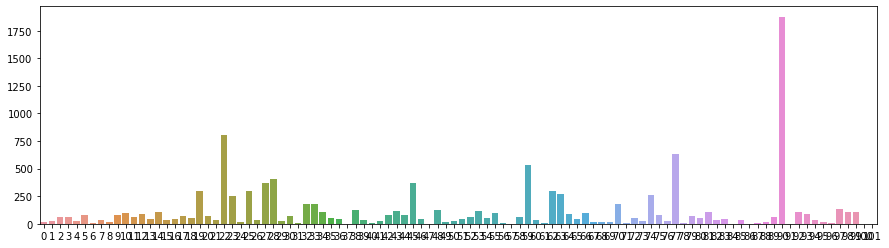

In [77]:
plt.figure(figsize=(15,4))
sns.barplot(frequent_location_with_advertisements['advertisement'].value_counts().keys(),frequent_location_with_advertisements['advertisement'].value_counts().values)

In [16]:
x.dtypes

presence_likelihood    float64
type_1                   int32
type_2                   int32
type_3                   int32
type_4                   int32
type_5                   int32
type_6                   int32
type_7                   int32
type_8                   int32
type_9                   int32
type_10                  int32
type_11                  int32
type_12                  int32
type_4_hours             int32
type_1_day               int32
type_7_days              int32
weekday                  int64
mins                     int64
hours                    int64
week_bfr_4_hours         int32
week_bfr_1_day           int32
week_bfr_7_days          int32
dtype: object

In [20]:
y_train.values

array(['Sports events', 'Nature', 'Car wash', ..., 'Car wash', 'Flowers',
       'Country'], dtype=object)